# Universal Inverse Problem Demo - grayscale images

## important: run this on GPU !!!!!!!!!!!

In [19]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'code')
from Utils_inverse_prob import *
from network import *
from algorithm_inv_prob import *
import argparse
from torch.autograd import Variable
import gzip

%matplotlib inline

## load denoiser

Load a denoiser from denoiser -> grayscale folder. You can swap this with any denoiser of your interest, as long as it is univeral (i.e. operates on different noise levels), is optimized to remove Gaussian noise, and its objective is to minimize mean square error. 

In [3]:
parser = argparse.ArgumentParser(description='BF_CNN_grayscale')
parser.add_argument('--dir_name', default= '../noise_range_')
parser.add_argument('--kernel_size', default= 3)
parser.add_argument('--padding', default= 1)
parser.add_argument('--num_kernels', default= 64)
parser.add_argument('--num_layers', default= 20)
parser.add_argument('--num_channels', default= 1)
args = parser.parse_args('')

model = Net(args)
if torch.cuda.is_available():
    model = model.cuda()

# change the path below to load another denoiser
model_path = 'denoisers/BF_CNN_grayscale/noise_range_0to100_mnits/model.pt'

if torch.cuda.is_available():
    learned_params =torch.load(model_path)
else:
    learned_params =torch.load(model_path, map_location='cpu' )


model.load_state_dict(learned_params)
model.eval();


## Synthesis

Sampling from the manifold, without any constrains. Starting from an arbitrary point in the space of images(more specifically, an image of Gaussian noise with large variance) we would like to take some steps towards the manifold embedded in the denoiser and eventually land on an arbitrary point on it. 

You will need to set the following hyperparamters: 

* $\sigma_0$: sig_0 is the sigma of the initial point. We need to start from a large sigma so that the final image contains coarse features as well. 

* $\sigma_L$: sig_L is the stopping criterion. When the noise remaining in the synthesized image reaches this level,  the algorithm stopps and accepts this as a clean image sampled from $p_{\sigma}(y) \approx p(x)$

* $h_0$: h0 is the step size. This controls the fraction of the denoising correction that is taken. 

* $\beta$: beta controls the amount of noise added in each iteration. If $\beta = 1$, no noise is added. With smaller values of $\beta$ more noise is added in each iteration. $\beta \in (0,1] $


Additionally, you can control the following 
* patch_size: patch size to be generated
* save_interm: Whether to save samples from intermediate steps
* freq: if save_interm is True, the frequency of storing samples

----------------------------- 20
sigma  0.576887309551239
----------------------------- 40
sigma  0.21079884469509125
----------------------------- 60
sigma  0.03415439650416374
-------- total number of iterations,  69
-------- average time per iteration (s),  0.0322
value range -0.01 0.95


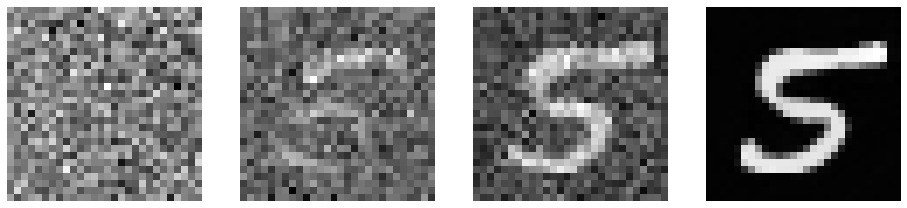

In [60]:
freq =20
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(torch.zeros((1,28,28))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.05, 
                                    beta = .05,   ### change beta to see how quality of generated samples change       
                                    save_interm=True)

## plot the progression and the final sample


plot_synthesis(intermed_Ys, sample)

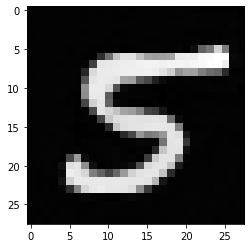

In [61]:
plt.imshow(sample.detach().squeeze(0), 'gray')

# Inverse probems


When using the algorithm to solve linear inverse problems, in addition to the hyperparameters described above, we need to provide the algorithm with the measurement matrix (i.e. the forward model). Here we provide 5 classes: inpainting, random pixel dropping, super resolution, deblurring, and measurements on random basis (i.e. compressive sensing). You can use the algorithm for any other linear inverse problems. 



## load a test image

Stick with smaller images if running on CPU

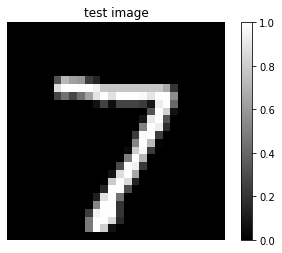

In [62]:
train_folder_path = '/Users/zahra/Documents/WORK/Research/0_Datasets_images/mnist/train-images-idx3-ubyte.gz'
test_folder_path = '/Users/zahra/Documents/WORK/Research/0_Datasets_images/mnist/t10k-images-idx3-ubyte.gz'

x = load_mnist_image(test_folder_path)


plt.imshow(x.squeeze(0), 'gray', vmin=0, vmax = 1)
plt.title('test image')
plt.colorbar()
plt.axis('off');


## 1. Inpainting



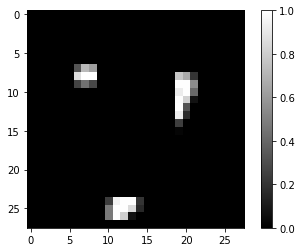

In [63]:
# class of inpaint has a forward method (M_T) for measurement and a inverse method, M, for reconstruction

inpaint = inpainting(x_size=x.size(), h=20,w=10)

plt.imshow(inpaint.M(inpaint.M_T(x)).squeeze(0), 'gray', vmin=0, vmax = 1)
plt.colorbar()

----------------------------- 20
sigma  0.8853996396064758
----------------------------- 40
sigma  0.7481662034988403
----------------------------- 60
sigma  0.5957430601119995
----------------------------- 80
sigma  0.5016469359397888
----------------------------- 100
sigma  0.38388746976852417
----------------------------- 120
sigma  0.26941782236099243
----------------------------- 140
sigma  0.2537560760974884
----------------------------- 160
sigma  0.16564175486564636
----------------------------- 180
sigma  0.1081480160355568
----------------------------- 200
sigma  0.0646834596991539
----------------------------- 220
sigma  0.03429380804300308
----------------------------- 240
sigma  0.012003912590444088
-------- total number of iterations,  244
-------- average time per iteration (s),  0.0298


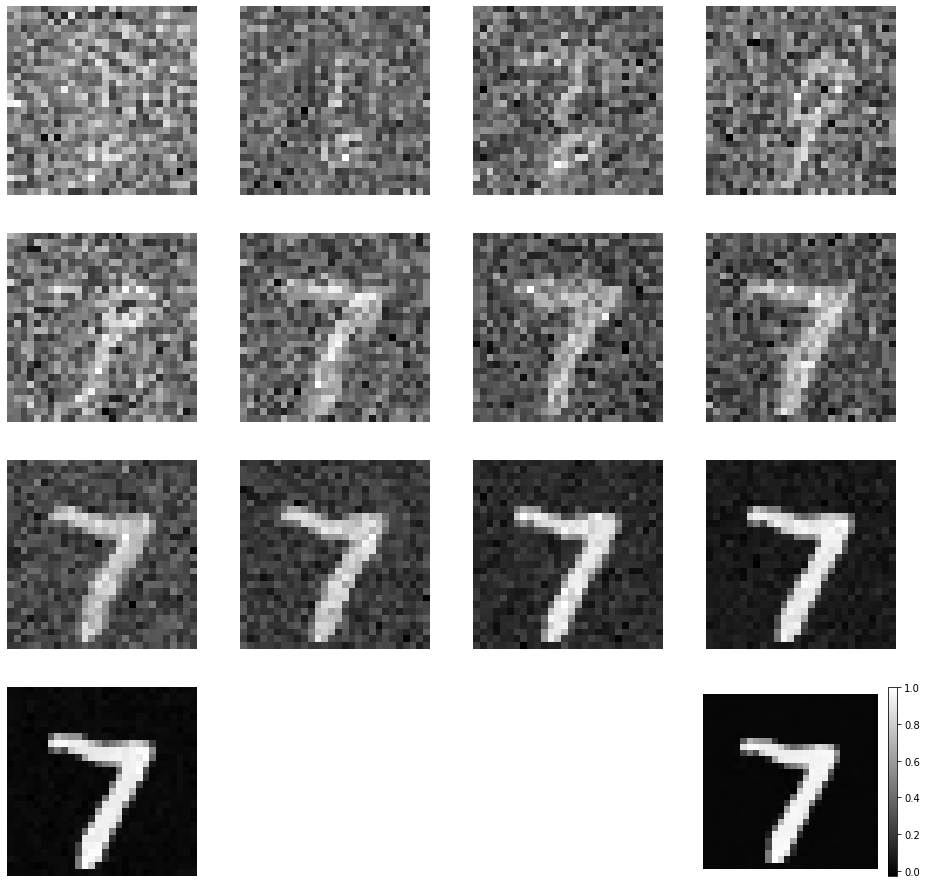

In [64]:
# In solving linear inverse problems, in order to get good quality samples, beta should be small, that is lots of 
# added noise in each iteration. 
# This gives the algorithm the freedom to explore the space and arrive at a point on the manifold where the 
# linear constraint is satisfied


sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= inpaint.M_T(x), 
                                    M_T= inpaint.M_T,
                                    M = inpaint.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = .01,          
                                    save_interm=True)
plot_all_samples(sample, intermed_Ys)

## 2. random pixel drop

----------------------------- 20
sigma  0.914370059967041
----------------------------- 40
sigma  0.7217493057250977
----------------------------- 60
sigma  0.690349280834198
----------------------------- 80
sigma  0.6504402160644531
----------------------------- 100
sigma  0.4273267686367035
----------------------------- 120
sigma  0.3136095702648163
----------------------------- 140
sigma  0.2795390784740448
----------------------------- 160
sigma  0.2097524255514145
----------------------------- 180
sigma  0.1132044866681099
----------------------------- 200
sigma  0.04602094739675522
----------------------------- 220
sigma  0.010758294723927975
-------- total number of iterations,  222
-------- average time per iteration (s),  0.0315


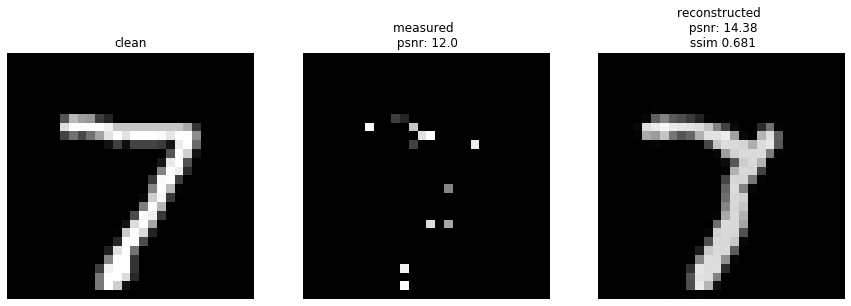

In [74]:
rand_pix = rand_pixels(x_size = x.size(), p =.1) # p=fraction of dimensions kept


sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_pix.M_T(x), 
                                    M_T= rand_pix.M_T,
                                    M = rand_pix.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=False)
## plot
plot_sample(x, rand_pix.M(rand_pix.M_T(x)), sample)

## 3. super resolution 


----------------------------- 20
sigma  0.9805417656898499
----------------------------- 40
sigma  0.8801782727241516
----------------------------- 60
sigma  0.7542333602905273
----------------------------- 80
sigma  0.6453990936279297
----------------------------- 100
sigma  0.5588906407356262
----------------------------- 120
sigma  0.45683571696281433
----------------------------- 140
sigma  0.312142550945282
----------------------------- 160
sigma  0.21649160981178284
----------------------------- 180
sigma  0.1479887068271637
----------------------------- 200
sigma  0.08954580128192902
----------------------------- 220
sigma  0.054032277315855026
----------------------------- 240
sigma  0.030971458181738853
----------------------------- 260
sigma  0.013283937238156796
-------- total number of iterations,  267
-------- average time per iteration (s),  0.0313


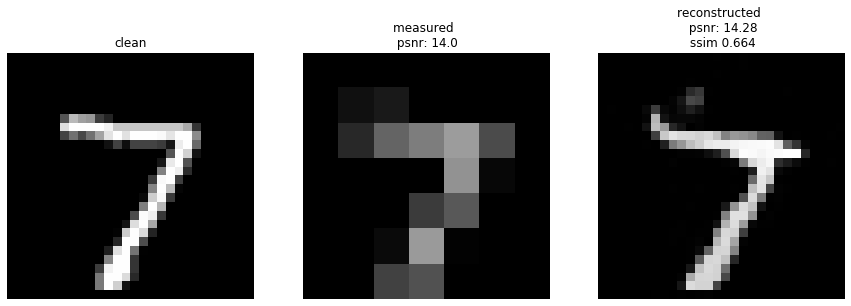

In [73]:

super_res = super_resolution(x_size=x.size(), s=4) # s=scale factor

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=super_res.M_T(x), 
                                    M_T= super_res.M_T,
                                    M = super_res.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.001, 
                                    beta = 0.1,          
                                    save_interm=False)

plot_sample(x,super_res.M(super_res.M_T(x)), sample)

## 4. Random basis

----------------------------- 20
sigma  0.9343856573104858
----------------------------- 40
sigma  0.847254753112793
----------------------------- 60
sigma  0.8116888999938965
----------------------------- 80
sigma  0.8214216232299805
----------------------------- 100
sigma  0.8352317214012146
----------------------------- 120
sigma  0.7287063002586365
----------------------------- 140
sigma  0.6312819123268127
----------------------------- 160
sigma  0.4850305914878845
----------------------------- 180
sigma  0.4245394170284271
----------------------------- 200
sigma  0.3517899811267853
----------------------------- 220
sigma  0.2447148859500885
----------------------------- 240
sigma  0.16276895999908447
----------------------------- 260
sigma  0.13207368552684784
----------------------------- 280
sigma  0.06620468199253082
----------------------------- 300
sigma  0.030735593289136887
-------- total number of iterations,  318
-------- average time per iteration (s),  0.0303


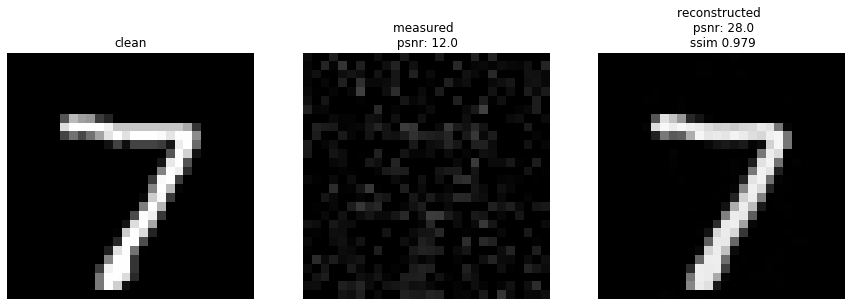

In [75]:
rand_basis = random_basis(x_size = x.shape , p=.1) # p=fraction of dimensions kept

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_basis.M_T(x), 
                                    M_T= rand_basis.M_T,
                                    M = rand_basis.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = .01,          
                                    save_interm=False)
# plot
plot_sample(x, rand_basis.M(rand_basis.M_T(x)), sample)

## 5. spectural super resolution

----------------------------- 20
sigma  0.9757808446884155
----------------------------- 40
sigma  0.8097910284996033
----------------------------- 60
sigma  0.7494564056396484
----------------------------- 80
sigma  0.49988609552383423
----------------------------- 100
sigma  0.41026610136032104
----------------------------- 120
sigma  0.35233333706855774
----------------------------- 140
sigma  0.24288952350616455
----------------------------- 160
sigma  0.1571117490530014
----------------------------- 180
sigma  0.0934918075799942
----------------------------- 200
sigma  0.038480814546346664
----------------------------- 220
sigma  0.009584001265466213
-------- total number of iterations,  221
-------- average time per iteration (s),  0.0292


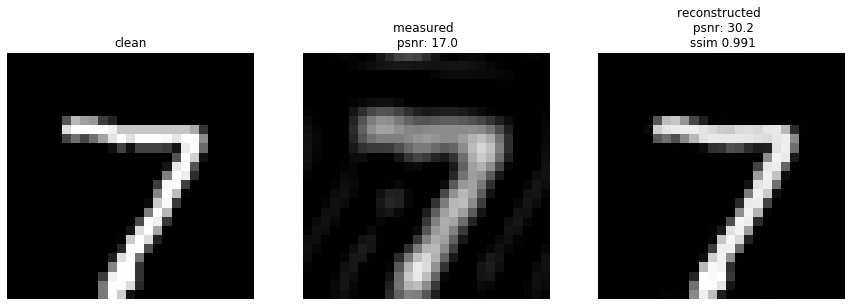

In [43]:
x = x[:,0:-1,0:-1]
spec_super_res = spectral_super_resolution( x_size=(x.shape[1], x.shape[2]), p = .34)

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=spec_super_res.M_T(x), 
                                    M_T= spec_super_res.M_T,
                                    M = spec_super_res.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=True)

plot_sample(x, spec_super_res.M(spec_super_res.M_T(x) ), sample)